In [1]:
import pandas as pd
Outflows = pd.read_parquet("q1-ucsd-outflows.pqt")
inflow = pd.read_parquet('q1-ucsd-inflows.pqt')
outflow = pd.read_parquet('q1-ucsd-outflows.pqt')

outflow_ids = set(outflow["prism_consumer_id"].unique())
inflow_ids = set(inflow["prism_consumer_id"].unique())

# Consumers in inflow but not in outflow
in_not_out = inflow_ids - outflow_ids
out_not_in = outflow_ids - inflow_ids


In [2]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import re

In [3]:
#consumers in both inflow and outflow
consumers_both = sorted(set(inflow["prism_consumer_id"]).intersection(outflow["prism_consumer_id"]))

#80-20 train test split
train_ids, test_ids = train_test_split(consumers_both, test_size=0.2, random_state=42)

inflow_train = inflow[inflow["prism_consumer_id"].isin(train_ids)]
inflow_test  = inflow[inflow["prism_consumer_id"].isin(test_ids)]

outflow_train = outflow[outflow["prism_consumer_id"].isin(train_ids)]
outflow_test  = outflow[outflow["prism_consumer_id"].isin(test_ids)]

In [4]:
pd.to_datetime(outflow_train['posted_date'], errors='coerce').iloc[0:10000].apply(lambda x:x.hour).unique()

array([0])

In [5]:
outflow_train[["memo", 'category', 'amount', 'posted_date']].sample(20)

,memo,category,amount,posted_date
1549922,ESSENTIAL_SERVICES,ESSENTIAL_SERVICES,221.14,2021-06-28
189417,Amazon,GENERAL_MERCHANDISE,96.28,2022-10-12
1081628,AUTOMOTIVE,AUTOMOTIVE,76.01,2023-03-22
2533514,EXTERNAL_TRANSFER,EXTERNAL_TRANSFER,50.00,2022-05-05
2170934,HEALTHCARE_MEDICAL,HEALTHCARE_MEDICAL,9.90,2021-08-12
492431,PURCHASE AUTHORIZED ON 06/29 ALAMO CAFE CA SXX...,FOOD_AND_BEVERAGES,16.94,2021-07-01
1155608,SELF_TRANSFER,SELF_TRANSFER,0.63,2022-05-30
1114358,AUTOMOTIVE,AUTOMOTIVE,94.57,2022-11-30
356979,ESSENTIAL_SERVICES,ESSENTIAL_SERVICES,1312.72,2022-06-16
1303192,XXXX XXXXXXXX SUNSHINE FOODS SUNSHINE FOODS HA...,GROCERIES,12.50,2022-06-30


In [6]:
outflow_train_1 = outflow_train[outflow_train["memo"] != outflow_train["category"]]

outflow_train_1

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
646,2,acc_3,PURCHASE AUTHORIZED ON 03/11 POKE POKU HENDERS...,35.08,2021-03-15,FOOD_AND_BEVERAGES
651,2,acc_3,PURCHASE AUTHORIZED ON 10/01 LIQUOR CITY HENDE...,43.83,2021-10-04,FOOD_AND_BEVERAGES
657,2,acc_3,PURCHASE INTL AUTHORIZED ON 10/20 Rituals Cosm...,98.27,2021-10-21,GENERAL_MERCHANDISE
658,2,acc_3,Trader Joe''s,152.61,2021-04-14,GROCERIES
660,2,acc_3,PURCHASE AUTHORIZED ON 05/28 VANS #174 LAS VEG...,81.17,2021-05-28,GENERAL_MERCHANDISE
...,...,...,...,...,...,...
2597457,5941,acc_9524,DEBIT CARD WITHDRAWAL PURCHASEAmazon Prime*TI4...,15.93,2023-01-16,GENERAL_MERCHANDISE
2597462,5941,acc_9524,POS WITHDRAWALAZ LOT QUIKTRIP XXXX XXXX E INDI...,25.00,2023-01-18,EDUCATION
2597465,5941,acc_9524,POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS ...,3.68,2023-01-18,FOOD_AND_BEVERAGES
2597468,5941,acc_9524,WITHDRAWAL Salt River ProjeTYPE: ONLINE PMT CO...,90.00,2023-01-20,FOOD_AND_BEVERAGES


/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


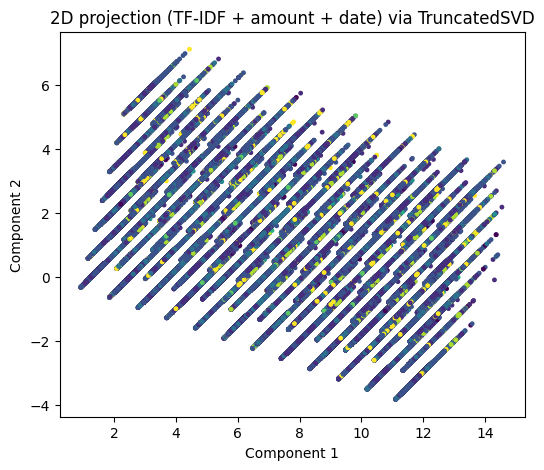

/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current pr

Linear separability (logistic regression) accuracy: 0.976529395710941


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# --- 0) Clean columns ---
df = outflow_train_1.dropna(subset=['cleaned_memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

X = df[['cleaned_memo','amount','posted_date']]
y = df['category']

# --- 1) Feature pipelines ---
# Amount: log1p -> scale
amount_pipe = make_pipeline(
    FunctionTransformer(lambda x: np.log1p(x.astype(float))),
    StandardScaler(with_mean=False)  # keep sparse compatibility
)



def date_features(X):
    # X can be a DataFrame (n,1) or a 2D array (n,1)
    if isinstance(X, pd.DataFrame):
        s = pd.to_datetime(X.iloc[:, 0], errors='coerce')
    else:
        X = np.asarray(X)
        s = pd.to_datetime(pd.Series(X.reshape(-1)), errors='coerce')

    hour = s.dt.hour.fillna(0).astype(int)
    dow  = s.dt.dayofweek.fillna(0).astype(int)   # Monday=0
    mon  = s.dt.month.fillna(0).astype(int)

    return np.column_stack([hour, dow, mon])

date_pipe = FunctionTransformer(date_features, validate=False)

# Text: TF-IDF (char/word choices are tunable)
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,5))

# --- 2) Column transformer (memo text + amount + date features) ---
pre = ColumnTransformer(
    transformers=[
        ('cleaned_memo', tfidf, 'cleaned_memo'),
        ('amount', amount_pipe, ['amount']),
        ('date', date_pipe, ['posted_date']),
    ],
    remainder='drop'
)

# --- 3) 2D projection for visualization (TruncatedSVD works on sparse) ---
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(pre.fit_transform(X))

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=pd.Categorical(y).codes, s=6)
plt.title("2D projection (TF-IDF + amount + date) via TruncatedSVD")
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.show()

# --- 4) Linear separability diagnostic: logistic regression (linear) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

linear_clf = Pipeline(steps=[
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=2000, multi_class='ovr', n_jobs=-1))
])
linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
print("Linear separability (logistic regression) accuracy:", accuracy_score(y_test, pred))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Device (safe fallback) ----
device = "mps" if torch.backends.mps.is_available() else "cpu"

df = outflow_train_1.dropna(subset=['cleaned_memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Device (safe fallback) ----
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda" 
else:
    device ="cpu"

# ==== NEW: numeric feature prep (scikit-learn) ====
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Load/clean as before
df = outflow_train_1.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

X_df = df[['memo','amount','posted_date']]
y_str = df['category'].astype(str)

# Label -> int64
le = LabelEncoder()
y_np = le.fit_transform(y_str).astype('int64')

# Date -> [hour, dow, month]
def date_features(Xcol):
    if isinstance(Xcol, pd.DataFrame):
        s = pd.to_datetime(Xcol.iloc[:,0], errors='coerce')
    else:
        Xcol = np.asarray(Xcol)
        s = pd.to_datetime(pd.Series(Xcol.reshape(-1)), errors='coerce')
    dow  = s.dt.dayofweek.fillna(0).astype(int)
    mon  = s.dt.month.fillna(0).astype(int)
    return np.column_stack([dow, mon])

date_pipe = Pipeline([
    ('extract', FunctionTransformer(date_features, validate=False)),
    ('scale', StandardScaler())
])

amount_pipe = make_pipeline(
    FunctionTransformer(lambda a: np.log1p(a.astype(float))),
    StandardScaler()
)

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,5))),
    ('svd', TruncatedSVD(n_components=128, random_state=42))
])

pre = ColumnTransformer(
    transformers=[
        ('memo', text_pipe, 'memo'),
        ('amount', amount_pipe, ['amount']),
        ('date', date_pipe, ['posted_date']),
    ],
    remainder='drop',
    sparse_threshold=0.0   # force dense
)

X_np = pre.fit_transform(X_df).astype('float32')   # << numeric features for Torch

# ==== Back to your original Torch code ====
X_t = torch.from_numpy(X_np).to(device)
y_t = torch.from_numpy(y_np).to(device)

dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

# ---- Model ----
class Categorio_V1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, output_features)  # raw logits for 9 classes
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model = Categorio_V1(input_features=X_np.shape[1], output_features=9, hidden_units=256).to(device)

# ---- Loss/Optimizer ----
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# ---- Train ----
model.train()
for epoch in range(10):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f"epoch {epoch+1}: loss {total_loss/len(loader):.4f}")

# ---- Evaluate ----
model.eval()
with torch.inference_mode():
    logits = model(X_t)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)

acc = (preds == y_t).float().mean().item()
print(f"Accuracy: {acc:.4f}")

/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


Accuracy: 0.8095


In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Device (safe fallback) ----
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda" 
else:
    device ="cpu"

# ==== NEW: numeric feature prep (scikit-learn) ====
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Load/clean as before
df = outflow_train_1.dropna(subset=['cleaned_memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

X_df = df[['cleaned_memo','amount','posted_date']]
y_str = df['category'].astype(str)

# Label -> int64
le = LabelEncoder()
y_np = le.fit_transform(y_str).astype('int64')

# Date -> [hour, dow, month]
def date_features(Xcol):
    if isinstance(Xcol, pd.DataFrame):
        s = pd.to_datetime(Xcol.iloc[:,0], errors='coerce')
    else:
        Xcol = np.asarray(Xcol)
        s = pd.to_datetime(pd.Series(Xcol.reshape(-1)), errors='coerce')
    dow  = s.dt.dayofweek.fillna(0).astype(int)
    mon  = s.dt.month.fillna(0).astype(int)
    return np.column_stack([dow, mon])

date_pipe = Pipeline([
    ('extract', FunctionTransformer(date_features, validate=False)),
    ('scale', StandardScaler())
])

amount_pipe = make_pipeline(
    FunctionTransformer(lambda a: np.log1p(a.astype(float))),
    StandardScaler()
)

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,5))),
    ('svd', TruncatedSVD(n_components=128, random_state=42))
])

pre = ColumnTransformer(
    transformers=[
        ('cleaned_memo', text_pipe, 'cleaned_memo'),
        ('amount', amount_pipe, ['amount']),
        ('date', date_pipe, ['posted_date']),
    ],
    remainder='drop',
    sparse_threshold=0.0   # force dense
)

X_np = pre.fit_transform(X_df).astype('float32')   # << numeric features for Torch

# ==== Back to your original Torch code ====
X_t = torch.from_numpy(X_np).to(device)
y_t = torch.from_numpy(y_np).to(device)

dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

# ---- Model ----
class Categorio_V1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)  # raw logits for 9 classes
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model = Categorio_V1(input_features=X_np.shape[1], output_features=9, hidden_units=256).to(device)

# ---- Loss/Optimizer ----
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# ---- Train ----
model.train()
for epoch in range(10):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f"epoch {epoch+1}: loss {total_loss/len(loader):.4f}")

# ---- Evaluate ----
model.eval()
with torch.inference_mode():
    logits = model(X_t)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)

acc = (preds == y_t).float().mean().item()
print(f"Accuracy: {acc:.4f}")

/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


Accuracy: 0.8189


In [65]:
pip install -U sentence-transformers transformers accelerate --quiet

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 1) Embed memos with a local transformer (no fine-tuning)
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np, pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
enc = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

@torch.no_grad()
def embed_text(texts, batch_size=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        m = enc(**t)
        emb = mean_pool(m.last_hidden_state, t["attention_mask"])  # [B, D]
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)       # (optional)
        outs.append(emb.cpu())
    return torch.cat(outs, dim=0).numpy().astype("float32")

# 2) Build your feature matrix: [embedding | log1p(amount) | hour | dow | month]
df = outflow_train_1.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

memo_emb = embed_text(df['memo'].astype(str).tolist())            # shape [N, D]

amt = np.log1p(df['amount'].astype(float).to_numpy())[:, None]
dow  = df['posted_date'].dt.dayofweek.to_numpy()[:, None]
mon  = df['posted_date'].dt.month.to_numpy()[:, None]

num_feats = np.concatenate([amt, dow, mon], axis=1).astype("float32")

X_np = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")
# y to int64
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_np = le.fit_transform(df['category'].astype(str)).astype("int64")

# 3) Back to your original Torch code (no change below this line)
import torch.nn.functional as F
X_t = torch.from_numpy(X_np).to(device)
y_t = torch.from_numpy(y_np).to(device)

dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

class Categorio_V1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model = Categorio_V1(input_features=X_np.shape[1], output_features=9, hidden_units=128).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

model.train()
for epoch in range(20):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

model.eval()
with torch.inference_mode():
    logits = model(X_t)
    preds = logits.argmax(dim=1)
    acc = (preds == y_t).float().mean().item()
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8867


In [14]:
model.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.0206,  0.0204,  0.0498,  ...,  0.0459, -0.0405, -0.2095],
                      [ 0.0277, -0.0336,  0.0055,  ..., -0.0286, -0.0412, -0.0900],
                      [ 0.0130, -0.0593, -0.0560,  ..., -0.0096, -0.0084, -0.2692],
                      ...,
                      [ 0.0181, -0.0342, -0.0217,  ...,  0.0073, -0.0117, -0.0326],
                      [ 0.0462, -0.0442, -0.0384,  ..., -0.0129, -0.0063, -0.0127],
                      [-0.1348,  0.0527, -0.0928,  ...,  0.0424, -0.2031, -0.5905]],
                     device='mps:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 1.1427e-01,  2.1050e-02,  1.4764e-01, -4.7979e-02,  1.0945e+00,
                      -4.2933e-02,  3.5479e-02,  4.8629e-02, -2.1047e-02, -1.9654e-01,
                       3.2143e+00, -2.3350e-02,  9.8858e-02,  8.0273e-02, -6.1109e-01,
                       3.7528e-03, -3.4043e-02, -2.8984e-02,  5.6175e-02,  5.902

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 0) Reuse your tokenizer/encoder and helpers defined above (tok, enc, embed_text, mean_pool)

def build_features(df):
    df = df.dropna(subset=['memo','category','amount','posted_date']).copy()
    df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
    df = df.dropna(subset=['posted_date'])

    memo_emb = embed_text(df['memo'].astype(str).tolist())  # [N, D]
    amt  = np.log1p(df['amount'].astype(float).to_numpy())[:, None]
    dow  = df['posted_date'].dt.dayofweek.to_numpy()[:, None]
    mon  = df['posted_date'].dt.month.to_numpy()[:, None]
    num_feats = np.concatenate([amt, dow, mon], axis=1).astype("float32")
    X = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")
    y_text = df['category'].astype(str).to_numpy()
    return X, y_text, df

# ---------- TRAIN ----------
X_tr_np, y_tr_txt, df_tr = build_features(outflow_train)  # NOTE: use outflow_train (not outflow_train_1)
le = LabelEncoder()
y_tr_np = le.fit_transform(y_tr_txt).astype("int64")

X_tr = torch.from_numpy(X_tr_np).to(device)
y_tr = torch.from_numpy(y_tr_np).to(device)

train_ds = torch.utils.data.TensorDataset(X_tr, y_tr)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)

n_out = len(le.classes_)
model = Categorio_V1(input_features=X_tr_np.shape[1], output_features=n_out, hidden_units=128).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

model.train()
for epoch in range(20):
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

# ---------- TEST ----------
X_te_np, y_te_txt, df_te = build_features(outflow_test)

# Handle any categories in test that did NOT appear in train
mask_known = np.isin(y_te_txt, le.classes_)
if not mask_known.all():
    # Optional: let you know how many/which were filtered
    unknown_ct = (~mask_known).sum()
    print(f"Filtered {unknown_ct} rows with unseen categories in test.")
X_te_np = X_te_np[mask_known]
y_te_txt = y_te_txt[mask_known]

y_te_np = le.transform(y_te_txt).astype("int64")

X_te = torch.from_numpy(X_te_np).to(device)
y_te = torch.from_numpy(y_te_np).to(device)

model.eval()
with torch.inference_mode():
    # If test is large, do it in batches to save memory
    bs = 1024
    preds_list = []
    for i in range(0, X_te.shape[0], bs):
        logits = model(X_te[i:i+bs])
        preds_list.append(logits.argmax(dim=1))
    preds = torch.cat(preds_list)

test_acc = (preds == y_te).float().mean().item()
print(f"Test Accuracy: {test_acc:.4f}")

KeyboardInterrupt: 

In [8]:
def build_features(df):
    df = df.dropna(subset=['memo','category','amount','posted_date']).copy()
    df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
    df = df.dropna(subset=['posted_date'])

    memo_emb = embed_text(df['memo'].astype(str).tolist())  # [N, D]
    amt  = np.log1p(df['amount'].astype(float).to_numpy())[:, None]
    dow  = df['posted_date'].dt.dayofweek.to_numpy()[:, None]
    mon  = df['posted_date'].dt.month.to_numpy()[:, None]
    num_feats = np.concatenate([amt, dow, mon], axis=1).astype("float32")
    X = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")
    y_text = df['category'].astype(str).to_numpy()
    return X, y_text, df

In [9]:
# 1) Embed memos with a local transformer (no fine-tuning)
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np, pandas as pd

tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
enc = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

@torch.no_grad()
def embed_text(texts, batch_size=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        m = enc(**t)
        emb = mean_pool(m.last_hidden_state, t["attention_mask"])  # [B, D]
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)       # (optional)
        outs.append(emb.cpu())
    return torch.cat(outs, dim=0).numpy().astype("float32")

# 2) Build your feature matrix: [embedding | log1p(amount) | hour | dow | month]
df = outflow_train_1.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

memo_emb = embed_text(df['memo'].astype(str).tolist())            # shape [N, D]

amt = np.log1p(df['amount'].astype(float).to_numpy())[:, None]
dow  = df['posted_date'].dt.dayofweek.to_numpy()[:, None]
mon  = df['posted_date'].dt.month.to_numpy()[:, None]

num_feats = np.concatenate([amt, dow, mon], axis=1).astype("float32")

X_np = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")
# y to int64
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_np = le.fit_transform(df['category'].astype(str)).astype("int64")

# 3) Back to your original Torch code (no change below this line)
import torch.nn.functional as F
X_t = torch.from_numpy(X_np).to(device)
y_t = torch.from_numpy(y_np).to(device)

dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

class Categorio_V2(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x): return self.net(x)

model_2 = Categorio_V2(d_in=X_np.shape[1], d_out=len(le.classes_), width=512, p=0.2).to(device)
optimizer = torch.optim.AdamW(model_2.parameters(), lr=1e-3, weight_decay=1e-4)
# Compute class weights (inverse frequency)
classes, counts = np.unique(y_np, return_counts=True)
class_weights = torch.tensor(1.0 / counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(classes)  # normalize

# Move to device
class_weights = class_weights.to(device)

# Use in your loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

model_2.train()
for epoch in range(20):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model_2(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

model_2.eval()
with torch.inference_mode():
    logits = model_2(X_t)
    preds = logits.argmax(dim=1)
    acc = (preds == y_t).float().mean().item()
print(f"Train accuracy: {acc:.4f}")

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


: 

In [ ]:
# 1) Embed memos with a local transformer (no fine-tuning)
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np, pandas as pd

tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
enc = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

@torch.no_grad()
def embed_text(texts, batch_size=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        m = enc(**t)
        emb = mean_pool(m.last_hidden_state, t["attention_mask"])  # [B, D]
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)       # (optional)
        outs.append(emb.cpu())
    return torch.cat(outs, dim=0).numpy().astype("float32")

# 2) Build your feature matrix: [embedding | log1p(amount) | dow | month]
df = outflow_train_1.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

memo_emb = embed_text(df['memo'].astype(str).tolist())            # shape [N, D]
amt = np.log1p(df['amount'].astype(float).to_numpy())[:, None]
dow  = df['posted_date'].dt.dayofweek.to_numpy()[:, None]
mon  = df['posted_date'].dt.month.to_numpy()[:, None]
num_feats = np.concatenate([amt, dow, mon], axis=1).astype("float32")

X_np = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")

# y to int64
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_np = le.fit_transform(df['category'].astype(str)).astype("int64")

# --- NEW: simple train/val split for the meta loop ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.1, random_state=42, stratify=y_np
)

# 3) Back to your original Torch code (no change below this line, except meta bits)
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

X_t = torch.from_numpy(X_train).to(device)
y_t = torch.from_numpy(y_train).to(device)
Xv_t = torch.from_numpy(X_val).to(device)
yv_t = torch.from_numpy(y_val).to(device)

train_ds = torch.utils.data.TensorDataset(X_t, y_t)
val_ds   = torch.utils.data.TensorDataset(Xv_t, yv_t)

loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=512, shuffle=True)

class Categorio_V3(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x): return self.net(x)

model_3 = Categorio_V3(d_in=X_np.shape[1], d_out=len(le.classes_), width=512, p=0.2).to(device)
optimizer = torch.optim.AdamW(model_3.parameters(), lr=1e-3, weight_decay=1e-4)
# Compute class weights (inverse frequency)
classes, counts = np.unique(y_np, return_counts=True)
class_weights = torch.tensor(1.0 / counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(classes)  # normalize

# Move to device
class_weights = class_weights.to(device)

# Use in your loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# --- NEW: helper to get a small validation minibatch iterator ---
import itertools
val_iter = itertools.cycle(val_loader)  # endless cycle of validation mini-batches

# --- NEW: one-step "probe" update to estimate validation effect of the current batch ---
@torch.no_grad()
def eval_val_loss(m, xv, yv):
    m.eval()
    logits_v = m(xv)
    return loss_fn(logits_v, yv).detach()

def meta_weight_for_batch(model, xb, yb, xv, yv, inner_lr=5e-4, sharpness=10.0):
    """
    Make a fast copy of the model, apply one SGD-like step on (xb, yb),
    then measure Δval = L_after - L_before. Convert to weight via sigmoid(-sharpness * Δval).
    """
    # 1) measure validation loss before
    with torch.no_grad():
        val_before = eval_val_loss(model, xv, yv)

    # 2) clone parameters (cheap state_dict copy)
    probe = deepcopy(model).to(device)
    probe.train()
    # manual one-step update on probe (SGD-style, not AdamW) to keep it light
    probe.zero_grad(set_to_none=True)
    logits = probe(xb)
    train_loss = loss_fn(logits, yb)
    grads = torch.autograd.grad(train_loss, probe.parameters(), create_graph=False)
    with torch.no_grad():
        for p, g in zip(probe.parameters(), grads):
            if g is not None:
                p.add_( -inner_lr * g )

    # 3) measure validation loss after the hypothetical update
    with torch.no_grad():
        val_after = eval_val_loss(probe, xv, yv)

    # 4) convert improvement into a weight in (0,1): improve -> weight ~ 1, hurt -> weight ~ 0
    delta = (val_after - val_before).clamp(min=-5.0, max=5.0)  # tame outliers
    w = torch.sigmoid(-sharpness * delta).item()
    return float(w)

# --- Training with meta-weighted batch losses ---
model_3.train()
for epoch in range(20):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        xv, yv = next(val_iter)
        xv = xv.to(device); yv = yv.to(device)

        # Compute a meta-derived weight for THIS batch (cheap, 1-step unroll)
        w_batch = meta_weight_for_batch(model_3, xb, yb, xv, yv, inner_lr=5e-4, sharpness=10.0)

        optimizer.zero_grad(set_to_none=True)
        logits = model_3(xb)
        loss = loss_fn(logits, yb)
        # --- NEW: scale the actual update by the meta weight ---
        (loss * w_batch).backward()
        optimizer.step()

        total_loss += loss.item()

# Final evals
model_3.eval()
with torch.inference_mode():
    logits_tr = model_3(X_t)
    preds_tr = logits_tr.argmax(dim=1)
    acc_tr = (preds_tr == y_t).float().mean().item()

    logits_va = model_3(Xv_t)
    preds_va = logits_va.argmax(dim=1)
    acc_va = (preds_va == yv_t).float().mean().item()

print(f"Train accuracy: {acc_tr:.4f} | Val accuracy: {acc_va:.4f}")

Train accuracy: 0.9744 | Val accuracy: 0.9662


In [35]:
import torch, joblib, numpy as np

torch.save({
    "state_dict": model_2.state_dict(),
    "d_in": X_np.shape[1],
    "width": 512,
    "p": 0.2,
    "classes": le.classes_.tolist(),
}, "categorio_v2.pt")

joblib.dump(le, "label_encoder.pkl")
print("Saved model to categorio_v2.pt and encoder to label_encoder.pkl")

Saved model to categorio_v2.pt and encoder to label_encoder.pkl


In [36]:
import torch, joblib, numpy as np

torch.save({
    "state_dict": model_3.state_dict(),
    "d_in": X_np.shape[1],
    "width": 512,
    "p": 0.2,
    "classes": le.classes_.tolist(),
}, "categorio_v3.pt")

joblib.dump(le, "label_encoder.pkl")
print("Saved model to categorio_v3.pt and encoder to label_encoder.pkl")

Saved model to categorio_v3.pt and encoder to label_encoder.pkl


In [ ]:
import torch, joblib, numpy as np
# Recreate your class
class Categorio_V2(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x): return self.net(x)


state = torch.load("categorio_v2.pt", map_location=device)
le = joblib.load("label_encoder.pkl")

model_2 = Categorio_V2(
    d_in=state["d_in"],
    d_out=len(state["classes"]),
    width=state.get("width", 512),
    p=state.get("p", 0.2),
).to(device)
model_2.load_state_dict(state["state_dict"])

# ensure LabelEncoder has same classes (needed if you didn't load joblib)
le.classes_ = np.array(state["classes"])
model_2.eval()

Categorio_V2(
  (net): Sequential(
    (0): Linear(in_features=387, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=9, bias=True)
  )
)

In [ ]:
import torch, joblib, numpy as np
# Recreate your class
class Categorio_V3(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x): return self.net(x)


state = torch.load("categorio_v3.pt", map_location=device)
le = joblib.load("label_encoder.pkl")

model_3 = Categorio_V3(
    d_in=state["d_in"],
    d_out=len(state["classes"]),
    width=state.get("width", 512),
    p=state.get("p", 0.2),
).to(device)
model_3.load_state_dict(state["state_dict"])

# ensure LabelEncoder has same classes (needed if you didn't load joblib)
le.classes_ = np.array(state["classes"])
model_3.eval()

Categorio_V3(
  (net): Sequential(
    (0): Linear(in_features=387, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=9, bias=True)
  )
)

In [58]:
le.classes_

array(['EDUCATION', 'FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE',
       'GROCERIES', 'MORTGAGE', 'OVERDRAFT', 'PETS', 'RENT', 'TRAVEL'],
      dtype='<U19')

In [39]:
outflow_test_1 = outflow_test[outflow_test['memo'] != outflow_test['category']]

In [ ]:
# 1) Embed memos with a local transformer (no fine-tuning)
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np, pandas as pd

tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
enc = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

@torch.no_grad()
def embed_text(texts, batch_size=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        m = enc(**t)
        emb = mean_pool(m.last_hidden_state, t["attention_mask"])  # [B, D]
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)       # (optional)
        outs.append(emb.cpu())
    return torch.cat(outs, dim=0).numpy().astype("float32")
X_te_np, y_te_txt, df_te = build_features(outflow_test_1)

Test Accuracy: 0.9093


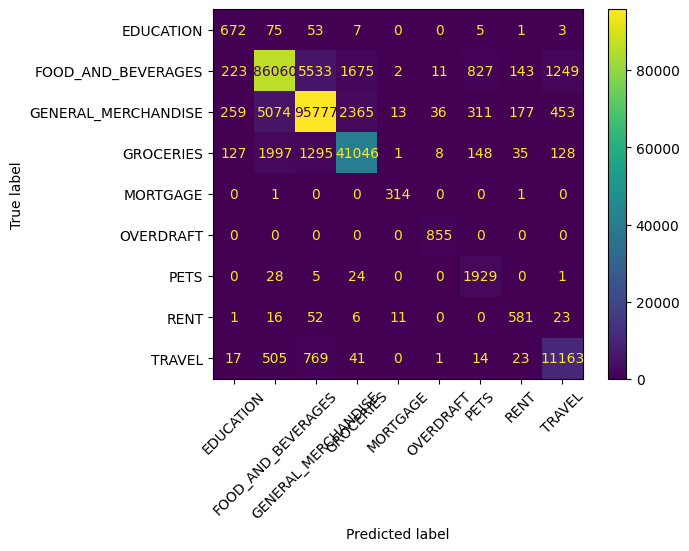

<Figure size 2000x3000 with 0 Axes>

In [76]:

# Filter unseen labels (or map to 'other' if you add such a class)
mask_known = np.isin(y_te_txt, le.classes_)
if not mask_known.all():
    unknown_ct = (~mask_known).sum()
    print(f"Filtered {unknown_ct} rows with unseen categories in test.")
X_te_np = X_te_np[mask_known]
y_te_txt = y_te_txt[mask_known]

y_te_np = le.transform(y_te_txt).astype("int64")
X_te = torch.from_numpy(X_te_np).to(device)
y_te = torch.from_numpy(y_te_np).to(device)

model_2.eval()
with torch.inference_mode():
    bs = 1024
    preds_list = []
    for i in range(0, X_te.shape[0], bs):
        logits = model_2(X_te[i:i+bs])
        preds_list.append(logits.argmax(dim=1))
    preds = torch.cat(preds_list)

test_acc = (preds == y_te).float().mean().item()
print(f"Test Accuracy: {test_acc:.4f}")

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If preds and y_te are torch tensors of class indices:
y_true = y_te.detach().cpu().numpy()
y_pred = preds.detach().cpu().numpy()

# If they’re integer-encoded (LabelEncoder), labels should be 0..n-1:
labels_idx = np.arange(len(le.classes_))
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)

# Nice labeled plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, colorbar=True)
plt.figure(figsize=(20,30))
plt.tight_layout()
plt.show()

Test Accuracy: 0.9093


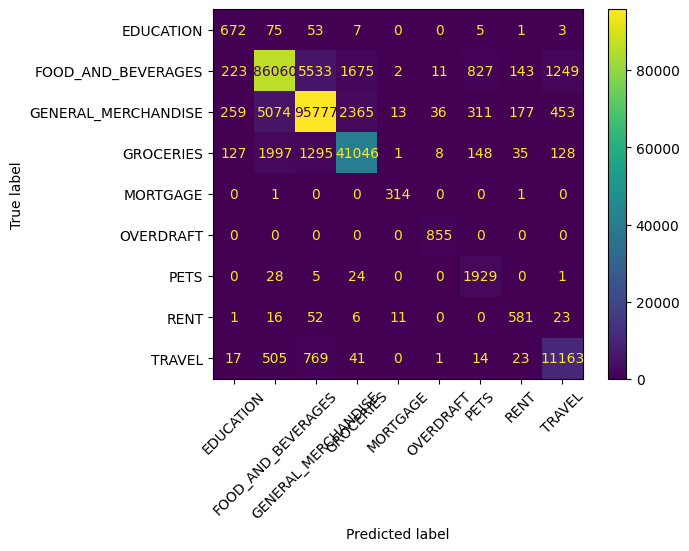

<Figure size 2000x3000 with 0 Axes>

In [77]:
# Filter unseen labels (or map to 'other' if you add such a class)
mask_known = np.isin(y_te_txt, le.classes_)
if not mask_known.all():
    unknown_ct = (~mask_known).sum()
    print(f"Filtered {unknown_ct} rows with unseen categories in test.")
X_te_np = X_te_np[mask_known]
y_te_txt = y_te_txt[mask_known]

y_te_np = le.transform(y_te_txt).astype("int64")
X_te = torch.from_numpy(X_te_np).to(device)
y_te = torch.from_numpy(y_te_np).to(device)

model_3.eval()
with torch.inference_mode():
    bs = 1024
    preds_list = []
    for i in range(0, X_te.shape[0], bs):
        logits = model_2(X_te[i:i+bs])
        preds_list.append(logits.argmax(dim=1))
    preds = torch.cat(preds_list)

test_acc = (preds == y_te).float().mean().item()
print(f"Test Accuracy: {test_acc:.4f}")


import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If preds and y_te are torch tensors of class indices:
y_true = y_te.detach().cpu().numpy()
y_pred = preds.detach().cpu().numpy()

# If they’re integer-encoded (LabelEncoder), labels should be 0..n-1:
labels_idx = np.arange(len(le.classes_))
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)

# Nice labeled plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, colorbar=True)
plt.figure(figsize=(20,30))
plt.tight_layout()
plt.show()

tensor([1, 1, 2,  ..., 2, 3, 1], device='mps:0')

In [3]:
import torch
from torch.optim import Adam
from datarater import InnerClassifier, DataRater

# fake dataset sizes
vocab_size = 500
num_classes = 5
pad_id = 0

# instantiate models
inner = InnerClassifier(vocab_size=vocab_size, num_classes=num_classes, pad_id=pad_id)
dr = DataRater(vocab_size=vocab_size, pad_id=pad_id)

# create random inputs
X = torch.randint(0, vocab_size, (8, 20))
Y = torch.randint(0, num_classes, (8,))

# forward passes
scores = dr(X)                 # (8,)
assert scores.shape == (8,)
per_ex = inner(X, Y)           # (8,)

# compute weighted loss
loss = (torch.softmax(scores, dim=0) * per_ex).sum()
loss.backward(create_graph=True)

print("✅ OK: shapes & autograd paths are good.")

✅ OK: shapes & autograd paths are good.


/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/torch/autograd/graph.py:829: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1296.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [4]:
df = Outflows[Outflows['memo'] != Outflows['category']]
df_train = df[:int(df.shape[0]*0.8)]
df_test = df[int(df.shape[0]*0.8):]

In [5]:
df_train

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
6,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
7,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
8,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE
...,...,...,...,...,...,...
2102262,5000,acc_8583,CHECKCARD XXXX APPLE.COM/BILL XXX-XXX-XXXX CA ...,16.44,2022-01-18,GENERAL_MERCHANDISE
2102264,5000,acc_8583,CHECKCARD XXXX DOORDASH*MANNA GRILL WWW.DOORDA...,51.47,2022-01-18,FOOD_AND_BEVERAGES
2102266,5000,acc_8583,PLANET FIT DES:CLUB FEES ID:XXXXXXXXXXXXX INDN...,10.00,2022-01-18,GENERAL_MERCHANDISE
2102271,5000,acc_8583,PURCHASE XXXX PP*APPLE.COM/BILL XXX-XXX-XXXX C...,21.94,2022-01-20,GENERAL_MERCHANDISE


In [7]:
# ---- 0) Inputs: a pandas DataFrame with columns: ["memo", "category"] ----
import pandas as pd
from collections import Counter
from typing import List, Dict, Tuple
import torch
from torch.utils.data import Dataset, DataLoader


import re
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

def memo_norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\d", "0", s)                   # collapse digits
    s = re.sub(r"[^a-z0-9 ]+", " ", s)          # keep letters/numbers/space
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ---- 0) Inputs: a pandas DataFrame with columns: ["memo", "category"] ----
import pandas as pd
from collections import Counter
from typing import List, Dict, Tuple
import torch
from torch.utils.data import Dataset, DataLoader


import re
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

def memo_norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\d", "0", s)                   # collapse digits
    s = re.sub(r"[^a-z0-9 ]+", " ", s)          # keep letters/numbers/space
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ---- 0) Clean & normalize (keep) ----
df_train['posted_date'] = pd.to_datetime(df_train['posted_date'], errors='coerce')
df_train = df_train.dropna(subset=['memo','category','amount','posted_date'])
df_train['memo_norm'] = df_train['memo'].astype(str).map(memo_norm)




# ---- 1) Tokenization & vocab ----
def basic_tokenize(text: str) -> List[str]:
    # Simple baseline; you can swap in a better tokenizer later
    return text.strip().lower().split()

def build_vocab(texts: List[str], min_freq: int = 1) -> Dict[str, int]:
    counter = Counter()
    for t in texts:
        counter.update(basic_tokenize(t))
    stoi = {"<pad>": 0, "<unk>": 1}
    for tok, freq in counter.items():
        if freq >= min_freq and tok not in stoi:
            stoi[tok] = len(stoi)
    return stoi

def encode_text(text: str, stoi: Dict[str, int]) -> List[int]:
    return [stoi.get(tok, stoi["<unk>"]) for tok in basic_tokenize(text)]


# ---- 2) Labels ----
def build_label_map(labels: List[str]) -> Dict[str, int]:
    classes = sorted(set(labels))
    return {c: i for i, c in enumerate(classes)}

def build_inverse_label_map(ltoi: Dict[str, int]) -> Dict[int, str]:
    return {i: c for c, i in ltoi.items()}


# ---- 3) Dataset + collate ----
class MemoDataset(Dataset):
    def __init__(self, df: pd.DataFrame, stoi: Dict[str,int], ltoi: Dict[str,int], max_len: int = 64):
        self.pad_id = stoi["<pad>"]
        self.samples = []
        for memo, label in zip(df["memo"].tolist(), df["category"].tolist()):
            ids = encode_text(str(memo), stoi)[:max_len]
            if label in ltoi:  # skip unseen labels (optional safeguard)
                self.samples.append((ids, ltoi[label]))
    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        x_ids, y = self.samples[idx]
        return torch.tensor(x_ids, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate_batch(batch, pad_id=0):
    xs, ys = zip(*batch)
    L = max(len(x) for x in xs) if xs else 1
    X = torch.full((len(xs), L), pad_id, dtype=torch.long)
    for i, x in enumerate(xs):
        X[i, :len(x)] = x
    return X, torch.stack(ys)

# ---- A) Split first (so we can build vocab on TRAIN ONLY) ----
from sklearn.model_selection import train_test_split
# If you have a user/account id, use stratify=... or GroupShuffleSplit by that id
train_df, val_df = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train['category']
)

# ---- B) Vocab & labels from TRAIN ONLY, using memo_norm ----
texts_train  = train_df['memo_norm'].astype(str).tolist()         # CHANGED
labels_train = train_df['category'].astype(str).tolist()

stoi = build_vocab(texts_train, min_freq=1)
ltoi = build_label_map(labels_train)
itol = build_inverse_label_map(ltoi)

pad_id = stoi["<pad>"]
MAX_LEN = 128                                                     # CHANGED

# ---- C) Dataset uses memo_norm ----
class MemoDataset(Dataset):
    def __init__(self, df: pd.DataFrame, stoi: Dict[str,int], ltoi: Dict[str,int], max_len: int = 128):
        self.pad_id = stoi["<pad>"]
        self.samples = []
        for memo, label in zip(df["memo_norm"].tolist(), df["category"].tolist()):  # CHANGED
            ids = encode_text(str(memo), stoi)[:max_len]
            if label in ltoi:
                self.samples.append((ids, ltoi[label]))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x_ids, y = self.samples[idx]
        return torch.tensor(x_ids, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def collate_batch(batch, pad_id=0):
    xs, ys = zip(*batch)
    L = max(len(x) for x in xs) if xs else 1
    X = torch.full((len(xs), L), pad_id, dtype=torch.long)
    for i, x in enumerate(xs):
        X[i, :len(x)] = x
    return X, torch.stack(ys)

# ---- D) Datasets / Loaders (same API) ----
train_ds = MemoDataset(train_df, stoi, ltoi, max_len=MAX_LEN)
val_ds   = MemoDataset(val_df,   stoi, ltoi, max_len=MAX_LEN)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,  collate_fn=lambda b: collate_batch(b, pad_id))
val_dl   = DataLoader(val_ds,   batch_size=128, shuffle=False, collate_fn=lambda b: collate_batch(b, pad_id))

# ---- E) Save maps for later inference ----
import json
json.dump(stoi, open("stoi.json","w"))
json.dump(ltoi, open("label_map.json","w"))

In [9]:
from inspect import signature
from datarater import DataRater
print(signature(DataRater.__init__))

(self, vocab_size: int, d_model: int = 128, max_seq_len: int = 128, pad_id: int = 0, dropout: float = 0.1, temperature: float = 1.0, learnable_temp: bool = False, shared_tok_emb: torch.nn.modules.sparse.Embedding = None)


In [11]:
import torch, itertools
from torch.optim import Adam
from datarater import InnerClassifier, DataRater, meta_step  # uses your file
from math import inf

device = torch.device("mps" if (hasattr(torch.backends,"mps") and torch.backends.mps.is_available())
                      else "cuda" if torch.cuda.is_available() else "cpu")

# 1) Build the DataRater (no shared emb unless you trained that way)
dr = DataRater(
    vocab_size=len(stoi),
    d_model=128,            # must match what you'll use at inference
    max_seq_len=128,
    pad_id=pad_id,
    temperature=1.0,
    learnable_temp=False,
    shared_tok_emb=None
).to(device)

# 2) Create a small population of inner classifiers + optimizers (stability)
POP = 2                     # 2–4 is plenty to start
def make_inner():
    m = InnerClassifier(vocab_size=len(stoi), num_classes=len(ltoi),
                        d_model=128, n_layers=2, n_heads=2,
                        max_seq_len=128, pad_id=pad_id, dropout=0.1).to(device)
    opt = Adam(m.parameters(), lr=1e-3)
    return m, opt

inner_models, inner_opts = zip(*[make_inner() for _ in range(POP)])

# 3) Meta-optimizer for the DataRater
meta_opt = Adam(dr.parameters(), lr=1e-3)

# 4) Make infinite batch iterators (train/val) that yield (x,y)
def make_batch_iter(dl):
    it = itertools.cycle(dl)
    while True:
        X, Y = next(it)        # your collate returns (X, Y)
        yield X.to(device), Y.to(device)

batch_iter_train = make_batch_iter(train_dl)
batch_iter_val   = make_batch_iter(val_dl)

# 5) Meta-training loop
best_loss = inf
for step in range(200):         # try 200 meta-steps to start
    meta_loss = meta_step(
        dr_model=dr,
        meta_opt=meta_opt,
        inner_models=inner_models,
        inner_opts=inner_opts,
        batch_iter_train=batch_iter_train,
        batch_iter_val=batch_iter_val,
        T=1                      # unroll 1 inner step per meta step (keeps memory low)
    )
    if (step+1) % 10 == 0:
        print(f"[meta step {step+1}] outer loss = {meta_loss:.4f}")
    # very simple checkpointing on best outer loss
    if meta_loss < best_loss:
        best_loss = meta_loss
        torch.save(dr.state_dict(), "datarater_best.pt")
        # optional: also save inner snapshot bundle if you want to resume fully

print("Saved best DataRater to datarater_best.pt (best outer loss:", best_loss, ")")

[meta step 10] outer loss = 1.0441
[meta step 20] outer loss = 0.7917
[meta step 30] outer loss = 0.7277
[meta step 40] outer loss = 1.0338
[meta step 50] outer loss = 0.8800
[meta step 60] outer loss = 1.0254
[meta step 70] outer loss = 0.7971
[meta step 80] outer loss = 0.8238
[meta step 90] outer loss = 0.7509
[meta step 100] outer loss = 1.1211
[meta step 110] outer loss = 0.7218
[meta step 120] outer loss = 0.6493
[meta step 130] outer loss = 0.9143
[meta step 140] outer loss = 0.6256
[meta step 150] outer loss = 0.5472
[meta step 160] outer loss = 0.7622
[meta step 170] outer loss = 0.8738
[meta step 180] outer loss = 0.6616
[meta step 190] outer loss = 0.6148
[meta step 200] outer loss = 0.5419
Saved best DataRater to datarater_best.pt (best outer loss: 0.4215903878211975 )


In [13]:
import torch, pandas as pd, numpy as np
from torch.utils.data import Dataset, DataLoader
from datarater import DataRater  # from your /mnt/data/datarater.py

# ----------- tokenizer / encoding helpers (same as training) -----------
def tok(s): return str(s).strip().lower().split()
def enc(s, stoi): return [stoi.get(t, stoi["<unk>"]) for t in tok(s)]
def pad(ids, L, pad_id): return ids[:L] + [pad_id] * max(0, L - len(ids))

class MemoDataset(Dataset):
    def __init__(self, df, stoi, ltoi, max_len=128):
        self.df = df.reset_index(drop=True)   # <- drop=True: now rows are 0..n-1
        self.stoi, self.ltoi, self.max_len = stoi, ltoi, max_len
        self.pad_id = stoi["<pad>"]
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        x_ids = enc(row["memo_norm"], self.stoi)
        y = self.ltoi[str(row["category"])] if "category" in self.df.columns else -1
        return pad(x_ids, self.max_len, self.pad_id), y, i  # <- return i (positional)

def collate(batch):
    xs, ys, idxs = zip(*batch)
    x = torch.tensor(xs, dtype=torch.long)
    y = torch.tensor(ys, dtype=torch.long)
    idxs = torch.tensor(idxs, dtype=torch.long)
    return x, y, idxs

# ----------- device -----------
device = torch.device("mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
                      else "cuda" if torch.cuda.is_available() else "cpu")

# ----------- build loader -----------
MAX_LEN = 128  # must match training
BATCH = 512
ds = MemoDataset(train_df, stoi, ltoi, max_len=MAX_LEN)
dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0, collate_fn=collate)

# ----------- load DataRater with your trained hyperparams -----------
# Use the same dims you inferred earlier for your classifier: d_model=128, n_layers=2, n_heads=2
dr = DataRater(
    vocab_size=len(stoi),
    d_model=128,
    max_seq_len=MAX_LEN,
    pad_id=stoi["<pad>"],
    temperature=1.0,          # use what you trained with
    learnable_temp=False      # use what you trained with
).to(device)

dr_ckpt = "datarater_best.pt"  # <-- change if different
dr.load_state_dict(torch.load(dr_ckpt, map_location=device))
dr.eval()

# ----------- score all memos -----------
all_scores = np.zeros(len(train_df), dtype=np.float32)
with torch.no_grad():
    for x, y, idxs in dl:
        x = x.to(device)
        s = dr(x)                    # (B,) raw scores
        all_scores[idxs.cpu().numpy()] = s.detach().cpu().float().numpy()

# Attach to the frame
train_scored = train_df.copy()
train_scored["dr_score"] = all_scores

In [14]:
p_keep = 0.60  # keep top 60%
th = np.quantile(train_scored["dr_score"].values, 1.0 - p_keep)
clean = train_scored[train_scored["dr_score"] >= th].reset_index(drop=True)

In [16]:
clean.to_csv("train_cleaned.csv", index=False)
print(len(train_df), "→ kept", len(clean), "rows")

836128 → kept 501677 rows


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Use your earlier val/test splits; here we assume you have val_df, test_df
# Train on CLEANED data only:
X_tr = clean["memo"].astype(str).tolist()
y_tr = clean["category"].astype(str).tolist()

X_val = val_df["memo"].astype(str).tolist()
y_val = val_df["category"].astype(str).tolist()

pipe = make_pipeline(
    TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), min_df=3, max_df=0.9),
    LogisticRegression(max_iter=200, n_jobs=-1,class_weight='balanced')
)

pipe.fit(X_tr, y_tr)
print("VAL\n", classification_report(y_val, pipe.predict(X_val)))

# Final test (the test set stayed untouched by DataRater):
X_te = df_test["memo"].astype(str).tolist()
y_te = df_test["category"].astype(str).tolist()
print("TEST\n", classification_report(y_te, pipe.predict(X_te)))

VAL
                      precision    recall  f1-score   support

          EDUCATION       0.70      0.95      0.80       791
 FOOD_AND_BEVERAGES       0.94      0.96      0.95     77960
GENERAL_MERCHANDISE       0.97      0.93      0.95     82956
          GROCERIES       0.95      0.97      0.96     35336
           MORTGAGE       0.90      1.00      0.95       216
          OVERDRAFT       0.98      1.00      0.99       550
               PETS       0.94      0.98      0.96      1551
               RENT       0.79      0.97      0.87       480
             TRAVEL       0.93      0.97      0.95      9193

           accuracy                           0.95    209033
          macro avg       0.90      0.97      0.93    209033
       weighted avg       0.95      0.95      0.95    209033

TEST
                      precision    recall  f1-score   support

          EDUCATION       0.45      0.92      0.60       543
 FOOD_AND_BEVERAGES       0.92      0.93      0.92     92197
GENERAL_M

In [22]:
Outflows[Outflows['category'] == 'EDUCATION']

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
2129,7,acc_14,"UNIVERSITY OF FLORIDA GAINESVILLE, FL, USA",20.70,2022-11-13,EDUCATION
3275,9,acc_20,South Central College,20.29,2019-08-26,EDUCATION
3281,9,acc_19,MSI CHICAGO HTTPSWWW.MSIC,59.85,2018-12-03,EDUCATION
4617,11,acc_26,DEBIT CARD PURCHASE XXXXXXXXX MLT SCHOOL XXXXX...,15.89,2022-04-12,EDUCATION
5585,13,acc_32,CHECKCARD XXXX ANIMAL HOSPITAL OF UNIV SUNRISE...,23.50,2022-03-02,EDUCATION
...,...,...,...,...,...,...
2587879,5922,acc_9505,AWL*PEARSON EDUCATION PRSONCS.COM NJ 0...,74.99,2022-06-13,EDUCATION
2589717,5928,acc_9511,SMC MANAGEMENT HOUSTON TX 1...,19.00,2021-11-02,EDUCATION
2595080,5935,acc_9518,Academy Sports,153.62,2022-08-04,EDUCATION
2596275,5940,acc_9523,WITHDRAWAL AT ATM #XXXXXX SCHOOLSFIRST XXXX/XX...,155.00,2022-10-04,EDUCATION


In [8]:
from torch.optim import Adam

def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # MPS (Apple Silicon)
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    return torch.device("cpu")

device = pick_device()
print("Using:", device)
inner = InnerClassifier(vocab_size=vocab_size, num_classes=num_classes, pad_id=pad_id,
                        d_model=128, n_layers=2, n_heads=4, max_seq_len=128).to(device)
dr    = DataRater(vocab_size=vocab_size, pad_id=pad_id, d_model=128, max_seq_len=128).to(device)

opt_inner = Adam(inner.parameters(), lr=2e-3)

def train_one_epoch():
    inner.train()
    for X, Y in train_dl:
        X, Y = X.to(device), Y.to(device)
        opt_inner.zero_grad(set_to_none=True)
        # DataRater weights (batch-softmax)
        scores  = dr(X)                               # (B,)
        weights = torch.softmax(scores, dim=0)        # sum=1
        per_ex  = inner(X, Y)                         # (B,)
        loss    = (weights * per_ex).sum()
        loss.backward()                               # no meta yet → no create_graph
        opt_inner.step()

def evaluate():
    inner.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, Y in val_dl:
            X, Y = X.to(device), Y.to(device)
            probs = inner.predict_proba(X)
            pred  = probs.argmax(dim=-1)
            correct += (pred == Y).sum().item()
            total   += Y.numel()
    return correct / max(total, 1)

for epoch in range(3):
    train_one_epoch()
    acc = evaluate()
    print(f"epoch {epoch}  val_acc={acc:.3f}")

Using: mps
epoch 0  val_acc=0.980
epoch 1  val_acc=0.983
epoch 2  val_acc=0.983


In [9]:
torch.save(inner.state_dict(), "classifier_train.pt")

In [10]:
inner.state_dict()

OrderedDict([('tok_emb.weight',
              tensor([[ 1.5495e-02,  2.5021e-02, -1.7392e-02,  ..., -4.9173e-07,
                       -2.9357e-03,  1.8349e-02],
                      [-5.3769e-03, -1.8638e-03,  4.5085e-02,  ..., -1.1101e-03,
                       -4.2432e-02,  3.8004e-03],
                      [ 2.1520e-01,  9.3443e-02, -1.8838e-01,  ...,  2.0460e-01,
                        7.0581e-01, -4.7834e-01],
                      ...,
                      [-2.4655e-02, -1.0483e-02, -5.5259e-02,  ...,  2.5449e-03,
                        2.6921e-02,  8.3801e-02],
                      [ 3.8601e-02, -6.9598e-02, -8.5731e-02,  ..., -4.7025e-02,
                       -2.0019e-02,  6.6491e-03],
                      [-1.0815e-01,  1.0717e-01,  1.2717e-02,  ..., -5.7956e-02,
                        2.6154e-02, -9.4048e-02]], device='mps:0')),
             ('pos_emb.weight',
              tensor([[-0.4390,  0.2731,  0.0634,  ...,  0.0147,  0.0731,  0.3116],
                    

In [11]:
import torch, re
from datarater import InnerClassifier

ckpt_path = "classifier_train.pt"
state = torch.load(ckpt_path, map_location="cpu")

# --- Infer dims from checkpoint ---
# d_model from norm size (LayerNorm is [d_model])
d_model = state["norm.weight"].shape[0]

# num_classes from head.bias or head.weight
num_classes = state["head.bias"].numel()

# vocab_size from tok_emb
vocab_size = state["tok_emb.weight"].shape[0]

# max_seq_len from pos_emb
max_seq_len = state["pos_emb.weight"].shape[0]

# n_layers: count distinct block indices in "blocks.{i}."
block_ids = set()
for k in state.keys():
    m = re.match(r"blocks\.(\d+)\.", k)
    if m: block_ids.add(int(m.group(1)))
n_layers = (max(block_ids) + 1) if block_ids else 0

# n_heads is not stored explicitly; try common divisors of d_model
def divisors(n):
    return [h for h in [2,3,4,6,8,12,16,24,32] if n % h == 0]

pad_id = 0  # must match your training pad id; if you saved it, use that

last_err = None
model = None
for h in divisors(d_model):
    try:
        tmp = InnerClassifier(
            vocab_size=vocab_size,
            num_classes=num_classes,
            d_model=d_model,
            n_layers=n_layers,
            n_heads=h,
            max_seq_len=max_seq_len,
            pad_id=pad_id
        )
        tmp.load_state_dict(state, strict=True)
        model = tmp
        n_heads = h
        break
    except Exception as e:
        last_err = e

if model is None:
    raise RuntimeError(f"Could not find matching n_heads. Last error:\n{last_err}")

print(f"Loaded with d_model={d_model}, n_layers={n_layers}, n_heads={n_heads}, "
      f"vocab_size={vocab_size}, max_seq_len={max_seq_len}")

model.eval()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

Loaded with d_model=128, n_layers=2, n_heads=2, vocab_size=146076, max_seq_len=128


InnerClassifier(
  (tok_emb): Embedding(146076, 128)
  (pos_emb): Embedding(128, 128)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-1): 2 x EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): FullSelfAttention(
        (qkv): Linear(in_features=128, out_features=384, bias=False)
        (o): Linear(in_features=128, out_features=128, bias=False)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_fea

In [12]:
import torch
import numpy as np

# must match your training maps
itol = {i: lbl for lbl, i in ltoi.items()}
device = next(model.parameters()).device

def tok(s): return str(s).strip().lower().split()
def enc(s): return [stoi.get(t, stoi["<unk>"]) for t in tok(s)]
def pad(ids, L, pad_id=stoi["<pad>"]): return ids[:L] + [pad_id]*max(0, L-len(ids))

@torch.no_grad()
def predict_batch(memos, max_len=128):
    X = torch.tensor([pad(enc(m), max_len) for m in memos], dtype=torch.long, device=device)  # [B,L]
    pos = torch.arange(X.size(1), device=device)                                              # [L]
    emb = model.tok_emb(X) + model.pos_emb(pos).unsqueeze(0)                                  # [B,L,E]
    h = model.drop(emb)
    kpm = X.eq(stoi["<pad>"])                                                                 # [B,L] bool

    # --- minimal fix: transpose for TransformerEncoderLayer and use src_key_padding_mask ---
    h = h.transpose(0, 1)                                                                     # [L,B,E]
    for blk in model.blocks:
        h = blk(h, src_key_padding_mask=kpm)                                                  # (B,L)
    h = h.transpose(0, 1)                                                                     # [B,L,E]
    # ---------------------------------------------------------------------------------------

    h = model.norm(h)
    mask = (~kpm).float()                                                                      # [B,L]
    pooled = (h * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True).clamp_min(1.)
    logits = model.head(pooled)
    probs  = torch.softmax(logits, dim=-1)
    pred_i = probs.argmax(dim=-1).tolist()
    conf   = probs.max(dim=-1).values.tolist()
    labels = [itol[i] for i in pred_i]
    return labels, conf

# --- minimal changes below: make lists; keep your counters if you like ---
samp = df_test
memos = samp['memo'].astype(str).tolist()
lable = samp['category'].astype(str).tolist()

labels, conf = predict_batch(memos)

lets_see = []
TP = TN = FP = FN = 0
score = 0
for m, y_pred, p, y_true in zip(memos, labels, conf, lable):
    if y_pred != y_true:
        print(f"{m} -> {y_pred} (conf={p:.2f})")
        if p > 0.5:
            FP += 1
        else:
            FN += 1
    if p > 0.5:
        TP += 1
    else:
        TN += 1
    score += (y_true == y_pred)

lets_see.append(score / len(lable))
print(np.mean(lets_see), TP, TN, FP, FN)

# (Optional but recommended) just print accuracy plainly:
print("Test accuracy:", score / len(lable))

TypeError: forward() got an unexpected keyword argument 'src_key_padding_mask'

In [18]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = 2/ (1/precision + 1/recall)
precision , recall, F1

(0.9866774682743937, 0.9992246006693447, 0.9929113974389563)

In [6]:
import torch, pandas as pd

# Use your already-loaded model, or load a state dict:
# state = torch.load("classifier_best.pt", map_location="cpu")
# OR:
state = model.state_dict()

rows = []
for name, t in state.items():
    tc = t.detach().float().cpu()
    rows.append({
        "name": name,
        "shape": list(tc.shape),
        "numel": tc.numel(),
        "dtype": str(t.dtype),
        "device": str(t.device),
        "min": float(tc.min()),
        "max": float(tc.max()),
        "mean": float(tc.mean()),
        "std": float(tc.std(unbiased=False)),
        "l2_norm": float(tc.pow(2).sum().sqrt())
    })

pres = pd.DataFrame(rows).sort_values("name").reset_index(drop=True)
pres

,name,shape,numel,dtype,device,min,max,mean,std,l2_norm
0,blocks.0.attn.o.weight,"[128, 128]",16384,torch.float32,mps:0,-2.233514,2.298670,0.001724,0.464791,59.493656
1,blocks.0.attn.qkv.weight,"[384, 128]",49152,torch.float32,mps:0,-2.044359,1.759205,0.000189,0.419697,93.047920
2,blocks.0.mlp.0.bias,[512],512,torch.float32,mps:0,-1.230220,0.657029,-0.588548,0.366855,15.692594
3,blocks.0.mlp.0.weight,"[512, 128]",65536,torch.float32,mps:0,-1.575785,1.734598,0.021587,0.338042,86.714966
4,blocks.0.mlp.3.bias,[128],128,torch.float32,mps:0,-2.161829,2.103722,0.031512,0.616614,6.985290
5,blocks.0.mlp.3.weight,"[128, 512]",65536,torch.float32,mps:0,-2.232433,1.999171,0.001183,0.356587,91.286713
6,blocks.0.norm1.bias,[128],128,torch.float32,mps:0,-0.546707,0.636345,0.008607,0.226516,2.564590
7,blocks.0.norm1.weight,[128],128,torch.float32,mps:0,-0.025367,2.091427,1.038799,0.420249,12.677979
8,blocks.0.norm2.bias,[128],128,torch.float32,mps:0,-1.265776,0.675613,-0.031521,0.282142,3.211929
9,blocks.0.norm2.weight,[128],128,torch.float32,mps:0,-0.055192,1.172793,0.584452,0.294564,7.404665


In [16]:
def peek(param_name, rows=(slice(0,4),), cols=(slice(0,8),)):
    t = state[param_name].detach().cpu()
    print(param_name, t.shape, t.dtype, t.device)
    # Handle 1D / 2D / 4D gracefully:
    if t.ndim == 1:
        print(t[: min(32, t.numel())])
    elif t.ndim == 2:
        print(t[rows[0], cols[0]])
    elif t.ndim == 3:
        print(t[rows[0], rows[1], cols[0]])
    elif t.ndim == 4:
        print(t[rows[0], rows[1], rows[2], cols[0]])
    else:
        print(t.flatten()[:256])  # fallback

# examples
peek("tok_emb.weight", rows=(slice(0,3),), cols=(slice(0,10),))
peek("blocks.0.attn.qkv.weight", rows=(slice(0,6),), cols=(slice(0,8),))
peek("head.weight", rows=(slice(0,3),), cols=(slice(0,12),))
peek("head.bias")

tok_emb.weight torch.Size([189314, 128]) torch.float32 cpu
tensor([[ 1.7324e-02,  2.6772e-02, -5.2560e-03, -1.9664e-02,  5.6287e-02,
          2.2791e-02,  1.1652e-02, -1.8856e-02, -3.4011e-02, -2.1831e-02],
        [-4.7696e-04,  1.2648e-02, -1.3801e-02, -5.3895e-03,  2.4270e-02,
          2.4151e-02, -2.3016e-02,  5.1935e-03,  7.1405e-03,  1.1005e-02],
        [ 2.9273e-01, -3.7156e-01,  8.2359e-02, -6.0847e-01, -7.3044e-01,
          1.3503e+00,  1.0965e-01, -4.4293e-01, -7.8866e-02, -1.4896e-01]])
blocks.0.attn.qkv.weight torch.Size([384, 128]) torch.float32 cpu
tensor([[-0.2021, -0.2309,  0.0014, -0.0775,  0.1467,  0.5393,  0.0785, -0.5746],
        [-0.7385, -0.0821,  0.0458, -0.4184, -0.1913, -0.2652,  0.0679, -0.2029],
        [-0.2881, -0.0245, -0.1996, -0.0560, -0.1948, -0.7308,  0.2055, -0.2253],
        [-0.7341, -0.0116,  0.0528, -0.6214, -0.3206, -0.1796,  0.3359, -0.2261],
        [-0.7271,  0.4578,  0.2841, -0.4900,  0.2235, -0.2144,  0.4120, -0.7498],
        [ 0.9282,

In [34]:
# exact & normalized memo overlap between train/val (should be ~0)
import re
def norm(s):
    s = s.lower()
    s = re.sub(r"\d","0",s)
    s = re.sub(r"[^a-z0-9 ]+"," ",s)
    s = re.sub(r"\s+"," ",s).strip()
    return s

train_m = set(train_df.memo.astype(str))
val_m   = set(val_df.memo.astype(str))
print("Exact overlap:", len(train_m & val_m))

train_n = set(train_df.memo.astype(str).map(norm))
val_n   = set(val_df.memo.astype(str).map(norm))
print("Normalized overlap:", len(train_n & val_n))

Exact overlap: 32914
Normalized overlap: 39666


In [35]:
# helper: top-k tokens by importance
def topk_attrib(ex, k=5):
    return sorted(ex, key=lambda t: t[1], reverse=True)[:k]

# inverse label map
idx2label = {i: c for c, i in ltoi.items()}

@torch.no_grad()
def predict_one(inner, memo, aux_row=None):
    ids = encode_text(str(memo), stoi)[:64]
    X = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)
    if hasattr(inner, "aux_proj") and aux_row is not None:
        AUX = torch.tensor(aux_row[AUX_COLS].values, dtype=torch.float32, device=device).unsqueeze(0)
        probs = inner.predict_proba(X, AUX)
    else:
        probs = inner.predict_proba(X)
    conf, pred = probs.max(dim=-1)
    return idx2label[int(pred.item())], float(conf.item())

itos = {i: s for s, i in stoi.items()}  # as before

# if df also has AUX columns, pass the row for aux-aware prediction; else pass None
for i, row in df.sample(20, random_state=0).iterrows():
    memo = row["memo"]
    # token attributions (your existing explainer)
    ex = explain_memo_gradxinput(inner, memo, stoi, itos, device=device)
    # prediction + confidence
    pred_lbl, conf = predict_one(inner, memo, aux_row=row if 'AUX_COLS' in globals() else None)

    print(memo)
    print(f" → pred={pred_lbl}  conf={conf:.2f}")
    for tok, score in topk_attrib(ex, k=5):
        print(f"{tok:>18s}  {score:.2f}")
    print()

NameError: name 'explain_memo_gradxinput' is not defined